# Crawford model

In [139]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
sns.set()

import sys  
sys.path.insert(0, '../scripts/')

from crawford_algorithm import Crawford

In [21]:
%load_ext autoreload

In [22]:
%autoreload 2

## Sampling from Crawford's model

In [186]:
model = Crawford()
graph = nx.gnp_random_graph(n=20, p=0.25, seed=31290)
data = model.simulating_rds_crawford(graph, n_samples=10, n_seeds=1, rate=1, probs=[0, 1/6, 1/6, 2/3], seed=312321)

100%|██████████| 9/9 [00:00<00:00, 17573.90it/s]


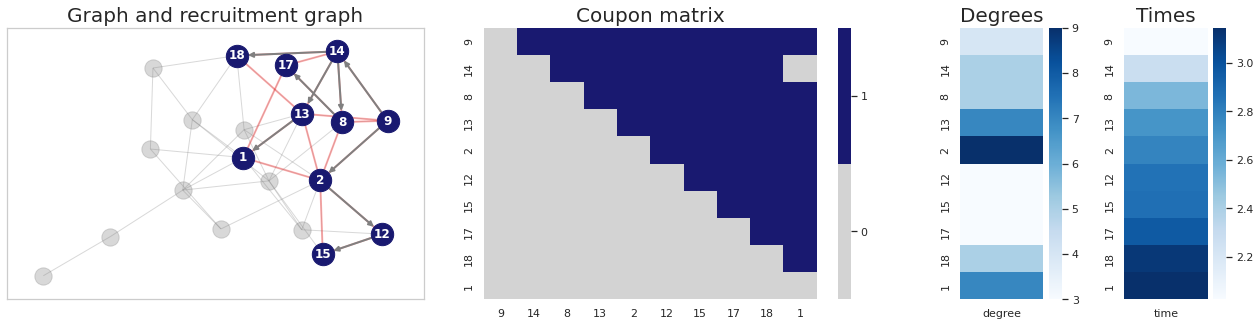

In [183]:
options = {
    'node_color': 'midnightblue',
    'node_size': 500,
    'with_labels': True,
    'font_weight': 'bold',
    'font_color': 'white',
    'edge_color': 'grey',
    'width': 2
}

sns.set(style='whitegrid')
fig, ax = plt.subplots(1, 4, figsize = (18,5), gridspec_kw={'width_ratios': [8, 8, 2, 2]})
pos = graphviz_layout(graph)
nx.draw_networkx_nodes(graph, pos, node_color='grey', alpha=0.3, ax=ax[0])
nx.draw_networkx_edges(graph, pos, edge_color='grey', alpha=0.3, ax=ax[0])
nx.draw_networkx_edges(graph.subgraph(data['rds'].nodes), pos, edge_color='red', alpha=0.3, width=2, ax = ax[0])
nx.draw_networkx(data['rds'], pos, **options, ax=ax[0])
ax[0].grid(False)

colors = ('lightgrey', 'midnightblue')
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
sns.heatmap(pd.DataFrame(data['C'], columns=list(data['rds'].nodes), index=list(data['rds'].nodes)), 
            ax=ax[1], cmap=cmap)
colorbar = ax[1].collections[0].colorbar
colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(['0', '1'])

sns.heatmap(pd.DataFrame(nx.get_node_attributes(data['rds'], 'degree').values(), 
                         columns=['degree'], index=nx.get_node_attributes(data['rds'], 'degree').keys()), 
            ax=ax[2], cmap='Blues')
sns.heatmap(pd.DataFrame(nx.get_node_attributes(data['rds'], 'time').values(), 
                         columns=['time'], index=nx.get_node_attributes(data['rds'], 'time').keys()), 
            ax=ax[3], cmap='Blues')

ax[0].set_title('Graph and recruitment graph', fontsize=20)
ax[1].set_title('Coupon matrix', fontsize=20)
ax[2].set_title('Degrees', fontsize=20)
ax[2].set_xlabel('')
ax[3].set_title('Times', fontsize=20)
ax[3].set_xlabel('')

fig.tight_layout(pad = 2)
plt.savefig('../images/crawford_mode_example.pdf', bbox_inches = 'tight')
plt.show()

sns.set()

In [213]:
a = np.ones((3,2))
a.sum(axis=0)

array([3., 3.])

In [212]:
a

array([[1., 1.],
       [1., 1.],
       [1., 1.]])

In [209]:
a

[5, 1, 2, 3]